root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: string (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)

Sample data from RDD:

Row(TransactionID='T1', CustomerID='C5841053', CustomerDOB='10/1/94', CustGender='F', CustLocation='JAMSHEDPUR', CustAccountBalance=17819.05, TransactionDate='2/8/16', TransactionTime=143207, TransactionAmount (INR)=25.0)
Row(TransactionID='T2', CustomerID='C2142763', CustomerDOB='4/4/57', CustGender='M', CustLocation='JHAJJAR', CustAccountBalance=2270.69, TransactionDate='2/8/16', TransactionTime=141858, TransactionAmount (INR)=27999.0)
Row(TransactionID='T3', CustomerID='C4417068', CustomerDOB='26/11/96', CustGender='F', CustLocation='MUMBAI', Cus

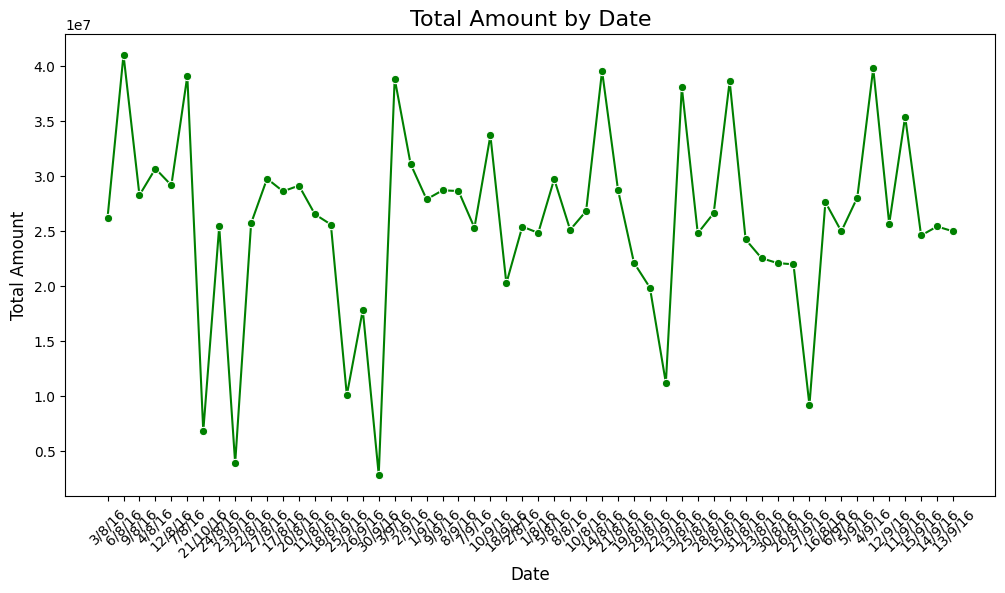

<ipython-input-10-69e0a8a80a76>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=date_counts_pd_df, x="Date", y="Count", palette="coolwarm")


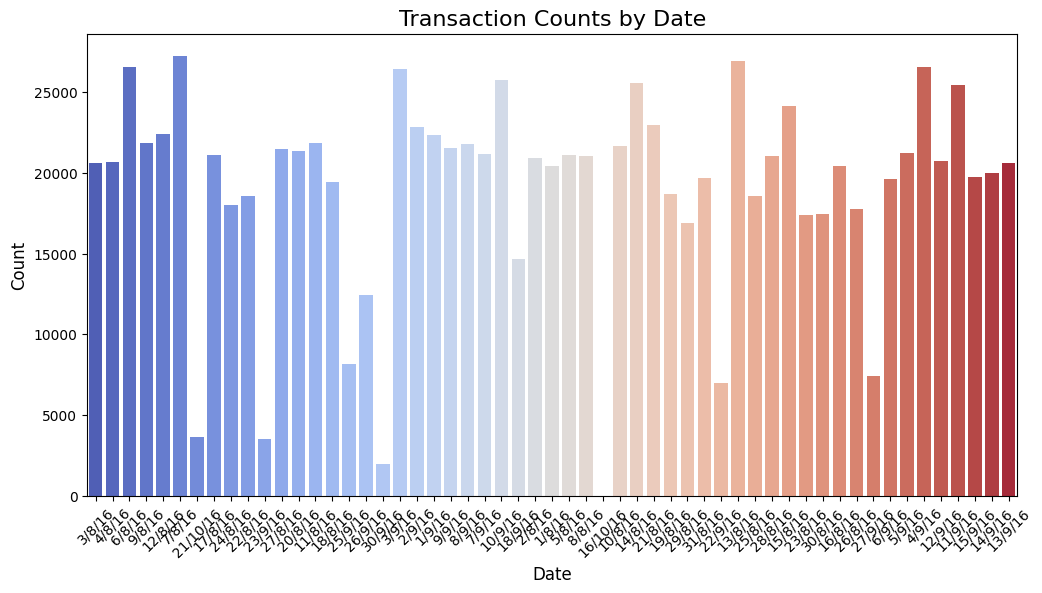

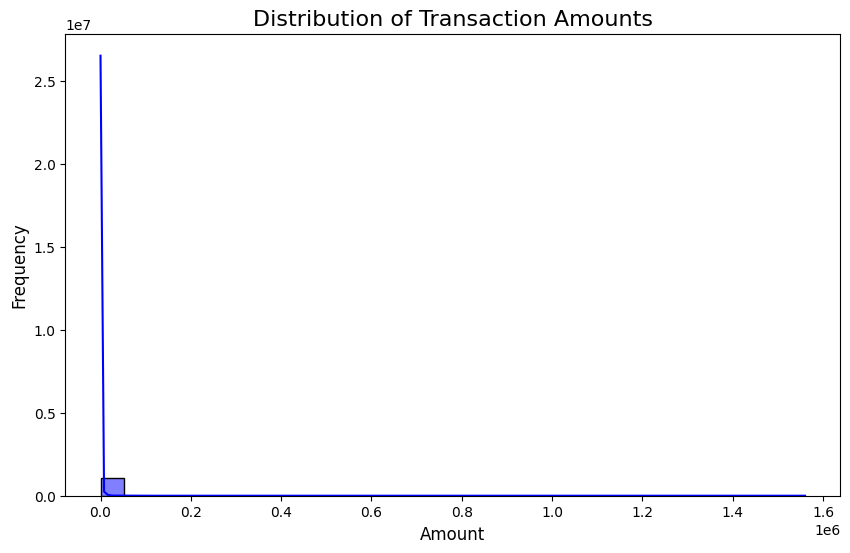

Insights and Inferences:

1. Total Transactions: 1048567

2. Average Transaction Amount: 1574.335003457067

3. Maximum Transaction Amount: 1560034.99

4. High-value transactions (amount > 1000) indicate potential key customers or significant events.

5. Transaction date analysis reveals daily patterns of activity.

6. Categorizing transactions as High or Low provides a simplified overview for decision-making.



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, avg, max, min, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.master("local[*]").appName("BankTransactionsAnalysis").getOrCreate()
file_path = "bank_transactions.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
rdd = df.rdd
df.printSchema()
print("Sample data from RDD:\n")
for row in rdd.take(5):
    print(row)

# ---------------- Transformations ------------------
# 1 Select specific columns
selected_rdd = rdd.map(lambda row: (
    row.TransactionID,
    row.CustomerID,
    row["TransactionAmount (INR)"],
    row.TransactionDate))

# 2 Filter transactions with an amount greater than 1000
high_value_rdd = selected_rdd.filter(lambda x: x[2] > 1000)

# 3 Group transactions by date and calculate the total amount for each date
date_grouped_rdd = high_value_rdd.map(lambda x: (x[3], x[2])).reduceByKey(lambda a, b: a + b)

# 4 categorizing transactions as "High" or "Low" based on the amount
categorized_rdd = selected_rdd.map(lambda x: x + ("High" if x[2] > 1000 else "Low",))

# 5 transactions sorting by amount in descending order
sorted_rdd = selected_rdd.sortBy(lambda x: x[2], ascending=False)

# 6 Deduplicating transactions based on TransactionID
deduplicated_rdd = selected_rdd.distinct()

# ------------------- Actions -----------------------
# 1 Count the total number of transactions
total_transactions = rdd.count()
print(f"Total Transactions: {total_transactions}\n")

print("First 5 rows:\n")
for row in rdd.take(5):
    print(row)

# 3 Calculate the average transaction amount
average_amount = rdd.map(lambda x: x["TransactionAmount (INR)"]).mean()
print(f"Average Transaction Amount: {average_amount}\n")

# 4 Find the maximum transaction amount
max_amount = rdd.map(lambda x: x["TransactionAmount (INR)"]).max()
print(f"Maximum Transaction Amount: {max_amount}\n")

# 5 Count the number of transactions for each date
date_counts = rdd.map(lambda x: (x.TransactionDate, 1)).reduceByKey(lambda a, b: a + b)
print("Transaction counts by date:\n")
for row in date_counts.collect():
    print(row)

# 6 Save the transformed data to a CSV file
categorized_df = categorized_rdd.toDF(["TransactionID", "CustomerID", "TransactionAmount (INR)", "TransactionDate", "Category"])
categorized_df.write.csv("categorized_transactions.csv", header=True, mode="overwrite")

# -------------Visualizations ---------------
date_grouped_pd_df = pd.DataFrame(date_grouped_rdd.collect(), columns=["Date", "TotalAmount"])
date_counts_pd_df = pd.DataFrame(date_counts.collect(), columns=["Date", "Count"])

# 1 Line plot for total amount by date
plt.figure(figsize=(12, 6))
sns.lineplot(data=date_grouped_pd_df, x="Date", y="TotalAmount", marker="o", color="green")
plt.title("Total Amount by Date", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Amount", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 2 Bar plot for transaction counts by date
plt.figure(figsize=(12, 6))
sns.barplot(data=date_counts_pd_df, x="Date", y="Count", palette="coolwarm")
plt.title("Transaction Counts by Date", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 3 Distribution of transaction amounts
amounts_rdd = rdd.map(lambda x: x["TransactionAmount (INR)"]).collect()
plt.figure(figsize=(10, 6))
sns.histplot(data=amounts_rdd, bins=30, kde=True, color="blue")
plt.title("Distribution of Transaction Amounts", fontsize=16)
plt.xlabel("Amount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# -------------Insights and Inference-----------------
print("Insights and Inferences:\n")
print(f"1. Total Transactions: {total_transactions}\n")
print(f"2. Average Transaction Amount: {average_amount}\n")
print(f"3. Maximum Transaction Amount: {max_amount}\n")
print("4. High-value transactions (amount > 1000) indicate potential key customers or significant events.\n")
print("5. Transaction date analysis reveals daily patterns of activity.\n")
print("6. Categorizing transactions as High or Low provides a simplified overview for decision-making.\n")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "bank_transactions.csv"
df = pd.read_csv(file_path)
print(df.head())
print(df.describe())
print(df.info)


  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5  
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count       

In [ ]:
#converting to DateTime
if 'TransactionDate' in df.columns:
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
    df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
    df['Month'] = df['TransactionDate'].dt.month
    df['Hour'] = df['TransactionDate'].dt.hour

#numerical columns
numerical_cols = ['CustAccountBalance', 'TransactionAmount (INR)']

#rolling mean and rolling sum
if 'CustomerID' in df.columns:
    df['RollingMean'] = df.groupby('CustomerID')['TransactionAmount (INR)'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    df['RollingSum'] = df.groupby('CustomerID')['TransactionAmount (INR)'].transform(lambda x: x.rolling(5, min_periods=1).sum())
    numerical_cols.extend(['RollingMean', 'RollingSum'])


<ipython-input-17-3d2d399005de>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


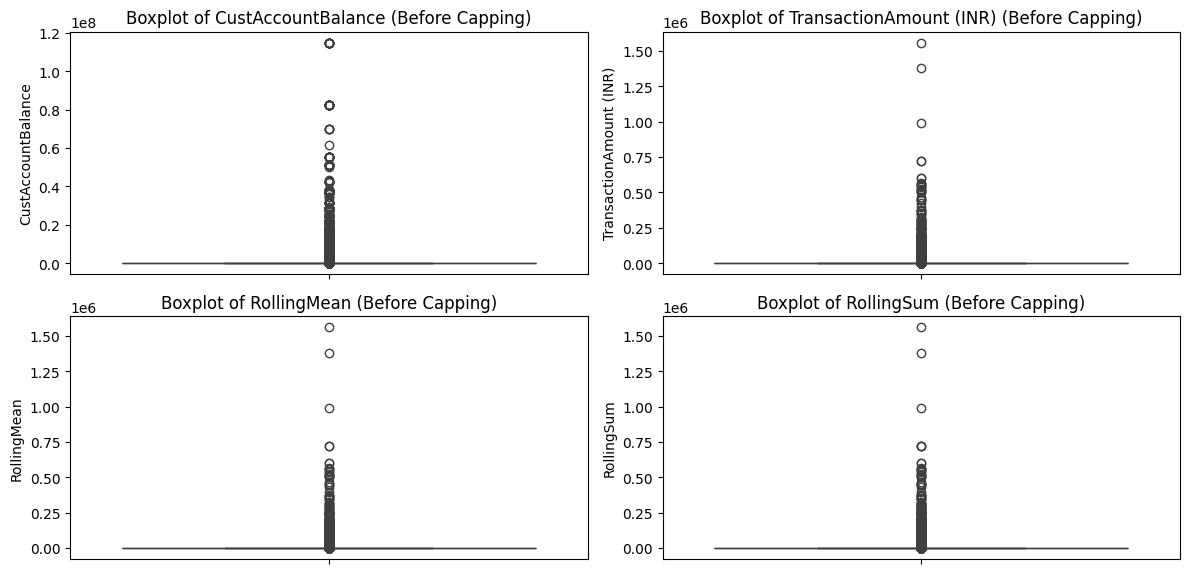

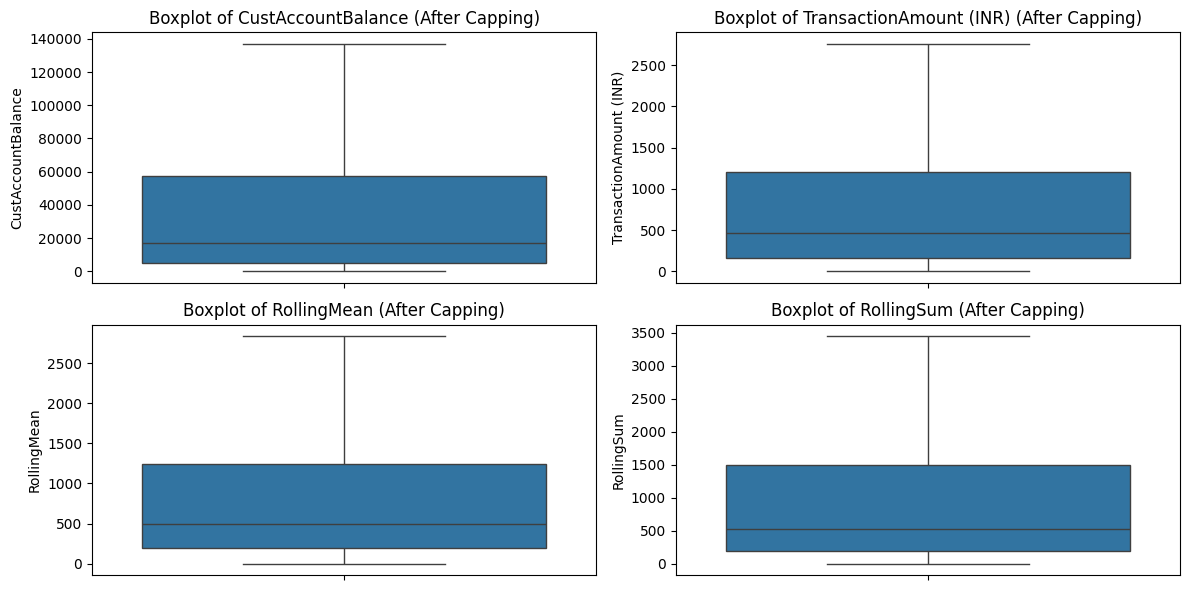

In [ ]:
#capping outliers using IQR method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

df_capped = df.copy()

#boxplots before
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col} (Before Capping)')
plt.tight_layout()
plt.show()

#capping numerical columns
for col in numerical_cols:
    df_capped = cap_outliers_iqr(df_capped, col)

#boxplots after capping outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_capped[col])
    plt.title(f'Boxplot of {col} (After Capping)')
plt.tight_layout()
plt.show()

In [ ]:
#Taking half of the data
df_capped = df_capped.sample(frac=0.5, random_state=42).reset_index(drop=True)

#Handling missing values
df_capped.fillna(df_capped.median(numeric_only=True), inplace=True)

#categorical variables
label_encoders = {}
for col in df_capped.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_capped[col] = le.fit_transform(df_capped[col])
    label_encoders[col] = le

#features and target
features = [col for col in df_capped.columns if col not in ['TransactionAmount (INR)', 'TransactionDate']]
target = 'TransactionAmount (INR)'

X = df_capped[features]
y = df_capped[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Linear Regression
linear=LinearRegression()
linear.fit(X_train_scaled, y_train)
y_pred_linear= ridge.predict(X_test_scaled)
print("linear Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_linaer))
print("MSE:", mean_squared_error(y_test, y_pred_linear))
print("R2 Score:", r2_score(y_test, y_pred_linear))

In [ ]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
print("Ridge Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R2 Score:", r2_score(y_test, y_pred_ridge))

Ridge Regression Results:
MAE: 108.82184244588092
MSE: 85530.02345596363
R2 Score: 0.8924969017039769


In [ ]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
print("Lasso Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R2 Score:", r2_score(y_test, y_pred_lasso))

Lasso Regression Results:
MAE: 108.89080892647635
MSE: 85526.13233631902
R2 Score: 0.8925017924709933


In [ ]:
# taking 10 sample values
sample_data = X_test.iloc[:10].values
sample_data_scaled = scaler.transform(sample_data)

predicted_amounts = lr.predict(sample_data_scaled)
median_transaction = df_capped[target].median()

for i, predicted_amount in enumerate(predicted_amounts):
    prediction_class = "High" if predicted_amount > median_transaction else "Low"
    print(f"Sample {i+1}: Predicted Transaction Amount: {predicted_amount}, Classification: {prediction_class}")

Sample 1: Predicted Transaction Amount: 141.17134061667218, Classification: Low
Sample 2: Predicted Transaction Amount: 261.5454205477264, Classification: Low
Sample 3: Predicted Transaction Amount: 756.3199792251144, Classification: High
Sample 4: Predicted Transaction Amount: 2608.041604551896, Classification: High
Sample 5: Predicted Transaction Amount: 2602.251417123656, Classification: High
Sample 6: Predicted Transaction Amount: 152.30944629333135, Classification: Low
Sample 7: Predicted Transaction Amount: 128.52819503233513, Classification: Low
Sample 8: Predicted Transaction Amount: 286.07369456755885, Classification: Low
Sample 9: Predicted Transaction Amount: 75.2056911244282, Classification: Low
Sample 10: Predicted Transaction Amount: 141.94252721343935, Classification: Low


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
